## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability) 
- [Part II - A/B Test](#ab_test) 
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 
It is important that getting some practice in working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability
importing needed libraries:

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#### Now, I will explore the data set
<br>Find the number of rows in the dataset:

In [3]:
df.shape[0]

294478

Find the number of unique users in the dataset:

In [4]:
df['user_id'].nunique()

290584

The proportion of users converted:

In [5]:
df['converted'].mean()*100

11.96591935560551

Do any of the rows have missing values?

In [6]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


I will see the number of times that the new_page and treatment don't match:

In [7]:
no_match1 = (df.query('group=="treatment" and landing_page!="new_page"'))
no_match2 = (df.query('group!="treatment" and landing_page=="new_page"'))

len(no_match1)+len(no_match2)

3893

 For the rows where treatment does not match with new_page or control does not match with old_page, we cannot be sure if this row truly received the new or old page.
 
So, I decided to remove these rows, and store the new dataframe in df2:

In [8]:
df2 = df.drop(no_match1.index)
df2 = df2.drop(no_match2.index)

df2.shape

(290585, 5)

Double Check all of the correct rows were removed - next output should be 0:

In [9]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Now, I will explore the second dataset **df2**

Number of unique user_ids are in df2:

In [10]:
df['user_id'].nunique()

290584

Seems to have one user_id repeated in df2!

In [11]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


I will see the row information for the repeated user_id

In [12]:
df2.query("user_id==773192")

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


I will remove one of the rows with a duplicate user_id

In [13]:
df2.drop(index=1899,inplace=True)
df2.query("user_id==773192")

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Now, everything seems to be good!<br>
I will find the probability of an individual converting regardless of the page they receive.

In [14]:
converted = df2['converted'].mean()
converted

0.11959708724499628

I will find the probability of an individual converting **Given that an individual was in the control group**:


In [15]:
controls = df2[df['group']=='control']['user_id'].count()
controls_and_converted = df2.query("group=='control' and converted == 1")['user_id'].count()
control_convert = controls_and_converted/controls

controls, controls_and_converted,control_convert

<ipython-input-15-6975dfedd05c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  controls = df2[df['group']=='control']['user_id'].count()


(145274, 17489, 0.1203863045004612)

I will find the probability of an individual converting **Given that an individual was in the treatment group**

In [16]:
treatment_and_converted = df2.query("group=='treatment' and converted == 1")['user_id'].count()
treatments = df2[df['group']=='treatment']['user_id'].count()
treatment_convert = treatment_and_converted/treatments
treatments,treatment_and_converted,treatment_convert

<ipython-input-16-a1ab6bdf67f5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  treatments = df2[df['group']=='treatment']['user_id'].count()


(145310, 17264, 0.11880806551510564)

Now, I will find the probability that an individual received the new page

In [17]:
new_page = df2.query('landing_page=="new_page"')['user_id'].count()
new_page/df2.shape[0]

0.5000619442226688

In [18]:
diff = treatment_convert - control_convert 
diff

-0.0015782389853555567

From the above results, it seems to be no sufficient evidence to conclude that
the new treatment page leads to more conversions!

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do I stop as soon as one page is considered significantly better than another?<br>
or does it need to happen consistently for a certain amount of time?
<br> How long do I run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

For now, I will consider making the decision just based on all the data provided.

I will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

These are the null and alternative hypotheses:

$$H_0 : P_{new} - P_{old} \leq0 $$
$$H_1 : P_{new} - P_{old} >0 $$

where 𝑝𝑜𝑙𝑑  and  𝑝𝑛𝑒𝑤  are the converted rates for the old and new pages.

I will assume under the null hypothesis,  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  both have "true" success rates equal to the converted success rate regardless of page - that is  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  are equal. 

Furthermore, I will assume they are equal to the converted rate in ab_data.csv regardless of the page.


I will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

I will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

And I will use the cells below to provide the necessary parts of this simulation.  

This might not make complete sense right now, don't worry - after working through the problems below will be clear. 

In [19]:
sample_size = df2.query('converted == 1')['user_id'].count()
sample_new = df2.sample(sample_size,replace=True)
sample_old = df2.sample(sample_size,replace=True)

sample_new['converted'].mean() - sample_old['converted'].mean()

0.0021293125773314547

Find the conversion rate for  𝑝𝑛𝑒𝑤  under the null:

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

Find the conversion rate for  𝑝𝑜𝑙𝑑  under the null:

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

Find the 𝑛𝑛𝑒𝑤 , the number of individuals in the treatment group:

In [22]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

 Find the 𝑛𝑜𝑙𝑑 , the number of individuals in the control group:

In [23]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

I will simulate  𝑛𝑛𝑒𝑤  transactions with a conversion rate of  𝑝𝑛𝑒𝑤  under the null, and store these  𝑛𝑛𝑒𝑤  1's and 0's in new_page_converted.

In [24]:
new_page_converted = np.random.choice(a=[0,1],size=n_new,p=[p_new,1-p_new])

I will simulate  𝑛𝑜𝑙𝑑  transactions with a conversion rate of  𝑝𝑜𝑙𝑑  under the null, and store these  𝑛𝑜𝑙𝑑  1's and 0's in old_page_converted.

In [25]:
old_page_converted = np.random.choice(a=[0,1],size=n_old,p=[p_old,1-p_old])

Find  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  for the simulated values above:

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.0009314245826935741

I will create 10,000  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  values using the same simulation process I used above. <br>I will store all 10,000 values in a NumPy array called p_diffs.

In [27]:
sample_size = df2['user_id'].count()
p_diffs = []

# for i in range(10000):
#     my_sample = df2.sample(sample_size,replace=True)
#     new_converted = np.random.choice([0,1],n_new,[p_new,1-p_new])
#     old_converted = np.random.choice([0,1],n_old,[p_old,1-p_old])
#     p_diffs.append( new_converted.mean() - old_converted.mean())


new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation


p_diffs = np.array(p_diffs)


I will plot a histogram of the p_diffs:

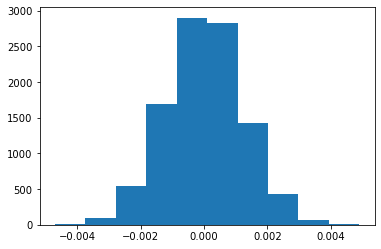

In [28]:
plt.hist(p_diffs);

This plot does not look like what I expected

I will find the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv

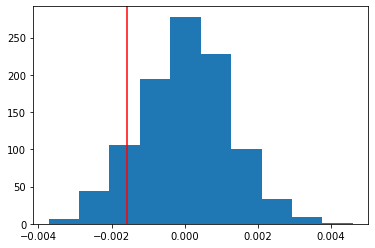

In [29]:
normal_dist = np.random.normal(0,p_diffs.std(),1000)
plt.hist(normal_dist);
plt.axvline(diff,color='r');

In [30]:
p_value = (normal_dist>diff).mean()
p_value

0.902

What I've just computed is the **P-value**, which is in this case too large 
this means that there is no significant difference if we add the new page, given that the null hypothesis is true
so the conclusion is that, **I failed to reject the null hypothesis**


I could also use a built-in to achieve similar results. 
Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

I will calculate the number of conversions for each page, as well as the number of individuals who received each page.

I will let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

Now I will use stats.proportions_ztest to compute my test statistic and p-value. 

In [32]:
sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

The z-score and p-value are not exaxtly the same as the conversion rates of the old and new pages! however, **they agree that we are fail to reject the null** since 0.91 is too large

<a id='regression'></a>
### Part III - Regression

In this final part, I will prove that the result I achieved in the A/B test in Part II above can also be achieved by performing regression.

Since each row is either a conversion or no conversion, The type of regression I will perform in this case is Logistic **Regression**

My goal is to use statsmodels to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives.

I will add an is_treatment column, which is 1 when an individual receives the treatment and 0 if control.

In [33]:
df2['intercept'] = 1
df2[['is_treatment','is_control']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop('is_control', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,is_treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


To predict whether or not an individual converts, I will use statsmodels to instantiate my regression model on the two columns I created above,then I will fit the model using the two columns I created.

In [34]:
log_model = sm.OLS(df2['converted'],df2[['intercept','is_treatment']])
result = log_model.fit()

I will provide the summary of my model:

In [35]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.000      
Dependent Variable: converted        AIC:                170538.6658
Date:               2020-11-14 21:39 BIC:                170559.8251
No. Observations:   290584           Log-Likelihood:     -85267.    
Df Model:           1                F-statistic:        1.719      
Df Residuals:       290582           Prob (F-statistic): 0.190      
R-squared:          0.000            Scale:              0.10529    
---------------------------------------------------------------------
                  Coef.   Std.Err.     t      P>|t|    [0.025  0.975]
---------------------------------------------------------------------
intercept         0.1204    0.0009  141.4066  0.0000   0.1187  0.1221
is_treatment     -0.0016    0.0012   -1.3109  0.1899  -0.0039  0.0008
--------------------------------------------------------------------
Omnibus:             125553.456     Durbin-Watson:        1.995     
Prob(Omnibus):       0.000          Jarque-Bera (JB):     414313.355
Skew:                2.345          Prob(JB):             0.000     
Kurtosis:            6.497          Condition No.:        3         
====================================================================

"""

The p-value associated with is_treatment is **0.1894**, which is also large and differ from the value I found in Part II
<br>
So, our model is not expected to predict well based on the landing page only:<br>
**Because in this regression model, these are the null and alternative hypotheses**<br>
$$H_0 : P_{new} - P_{old} =0 $$
$$H_1 : P_{new} - P_{old} \neq0 $$
<br>**However in part2** <br>
$$H_0 : P_{new} - P_{old} \leq0 $$
$$H_1 : P_{new} - P_{old} >0 $$


**So, We have to consider other factors** that might influence whether or not an individual converts because the individual will not convert based on only one condition.

However adding too much factors **might be considered as disadvantages** and will make it more complex and maybe inaccurate. 

Now, to see that if country had an impact on conversion, I will also add an effect based on which country a user lives in.

I will read in the countries.csv dataset and merge together my datasets.

In [36]:
#joining
country_data = pd.read_csv('countries.csv')
df3 = df2.join(country_data.set_index('user_id'), on = 'user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,is_treatment,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [37]:
#create dummies
df3.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [38]:
df3[['CA', 'UK', 'US']]= pd.get_dummies(df3['country'])

Create interaction variables:

In [39]:
df3['ab_UK'] = df3['is_treatment'] * df3['UK']
df3['ab_CA'] = df3['is_treatment'] * df3['CA']
df3['ab_US'] = df3['is_treatment'] * df3['US']

df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,is_treatment,country,CA,UK,US,ab_UK,ab_CA,ab_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


Create a regression model:

In [40]:
log_model2 = sm.Logit(df3['converted'], df3[['intercept', 'is_treatment', 'CA', 'US', 'ab_CA', 'ab_US']])

I would like to look at an interaction between page and country to see if there significant effects on conversion.
I will fit the new model and provide the summary results, and conclud based on the results.

In [41]:
result2 = log_model2.fit();
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2020-11-14 21:39 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9922   0.0161 -123.4571 0.0000 -2.0238 -1.9606
is_treatment      0.0108   0.0228    0.4749 0.6349 -0.0339  0.0555
CA               -0.0118   0.0398   -0.2957 0.7674 -0.0899  0.0663
US                0.0057   0.0188    0.3057 0.7598 -0.0311  0.0426
ab_CA            -0.0783   0.0568   -1.3783 0.1681 -0.1896  0.0330
ab_US            -0.0314   0.0266   -1.1807 0.2377 -0.0835  0.0207
==================================================================

"""

In [42]:
np.exp(0.0108),np.exp(-0.0118),np.exp(0.0057),np.exp(-0.0783),np.exp(-0.0314)

(1.010858530520097,
 0.9882693469672547,
 1.0057162759095335,
 0.9246869788348134,
 0.9690878603945013)

**is_treatment**: 1.010858530520097
<br>**US**: 1.0057162759095335

Since some are less than1 , will take 1/exp

In [43]:
1/np.exp(-0.0118),1/np.exp(-0.0783),1/np.exp(-0.0314)

(1.011869894648401, 1.0814470441230692, 1.0318981806179213)

**CA** : 1.011869894648401
<br>**ab_CA** :1.0814470441230692
<br>**ab_US** : 1.0318981806179213

I made UK as the baseline so that I excluded it from my model 

<ol>
<li>US users are 1.01 times less likely to convert as UK users. </li>
<li>CA users are 1.05 times less likely to convert as UK users. </li>
</ol>
and again, with these large P-values, there is no statistically significant of the effect and we failed to reject the null.
<br>

So , based on my findings as a data analyst, in all three parts, using the data set **ab_data.csv**, my advice for the company is to maintain the old page and not implement the new page.